In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# 1. Load data

In [ ]:
data=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [58]:
data.shape

(7043, 21)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [60]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [61]:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [62]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# 2. Data Cleaning

In [63]:
data = data.drop('customerID', axis=1)

In [64]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [65]:
# Convert 'TotalCharges' to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

In [66]:
# Separate categorical and numerical columns
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'
]
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("Categorical Columns:\n", categorical_cols)
print("\nNumerical Columns:\n", numerical_cols)

Categorical Columns:
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Numerical Columns:
 ['tenure', 'MonthlyCharges', 'TotalCharges']


In [67]:
# copy the data
eda_data = data.copy()

In [68]:
# encode categorical columns  for binary columns
label_enc_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                  'PaperlessBilling', 'Churn']
le = LabelEncoder()
for col in label_enc_cols:
    data[col] = le.fit_transform(data[col])

In [69]:
# encode categorical columns  for multi class columns
one_hot_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                'Contract', 'PaymentMethod']

data = pd.get_dummies(data, columns=one_hot_cols, drop_first=True)

In [70]:
print("Encoded Dataset Shape:", data.shape)
print("\nEncoded Columns:\n", data.columns)

Encoded Dataset Shape: (7043, 31)

Encoded Columns:
 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [71]:
# Convert all boolean columns to integers (0/1)
data = data.astype({col: int for col in data.select_dtypes(include='bool').columns})

In [72]:
data.dtypes

gender                                     int32
SeniorCitizen                              int64
Partner                                    int32
Dependents                                 int32
tenure                                     int64
PhoneService                               int32
PaperlessBilling                           int32
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int32
MultipleLines_No phone service             int32
MultipleLines_Yes                          int32
InternetService_Fiber optic                int32
InternetService_No                         int32
OnlineSecurity_No internet service         int32
OnlineSecurity_Yes                         int32
OnlineBackup_No internet service           int32
OnlineBackup_Yes                           int32
DeviceProtection_No internet service       int32
DeviceProtection_Yes                       int32
TechSupport_No inter

# 3. EDA

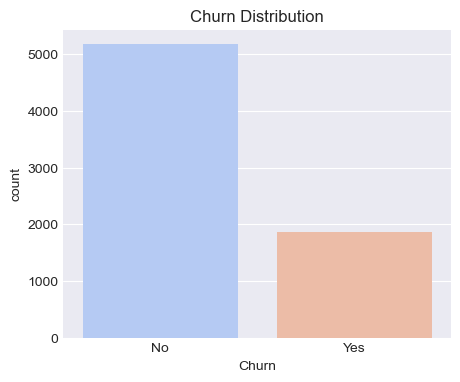

In [73]:
#Churn Distribution
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=eda_data, palette='coolwarm')
plt.title("Churn Distribution")
plt.show()

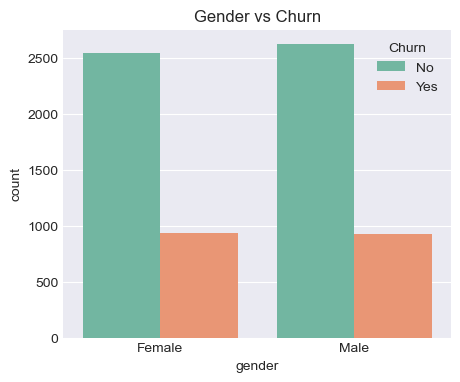

In [74]:
# Gender vs Churn
plt.figure(figsize=(5,4))
sns.countplot(x='gender', hue='Churn', data=eda_data, palette='Set2')
plt.title("Gender vs Churn")
plt.show()

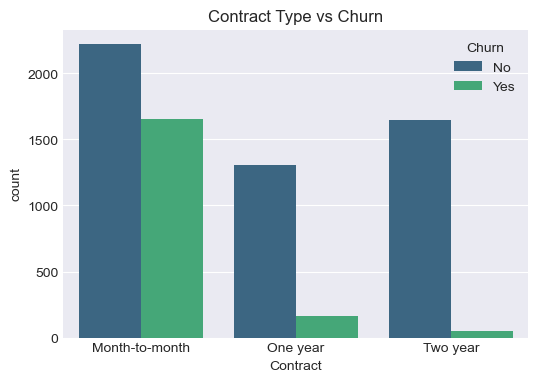

In [75]:
# Contract Type vs Churn
plt.figure(figsize=(6,4))
sns.countplot(x='Contract', hue='Churn', data=eda_data, palette='viridis')
plt.title("Contract Type vs Churn")
plt.show()

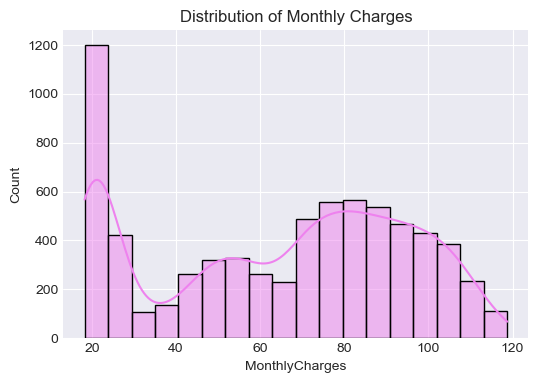

In [76]:
# Monthly Charges Distribution
plt.figure(figsize=(6,4))
sns.histplot(eda_data['MonthlyCharges'], kde=True, color='violet')
plt.title("Distribution of Monthly Charges")
plt.show()

In [77]:
import math
# Set up the subplot grid
n_cols = 3  # number of plots per row
n_rows = math.ceil(len(categorical_cols) / n_cols)

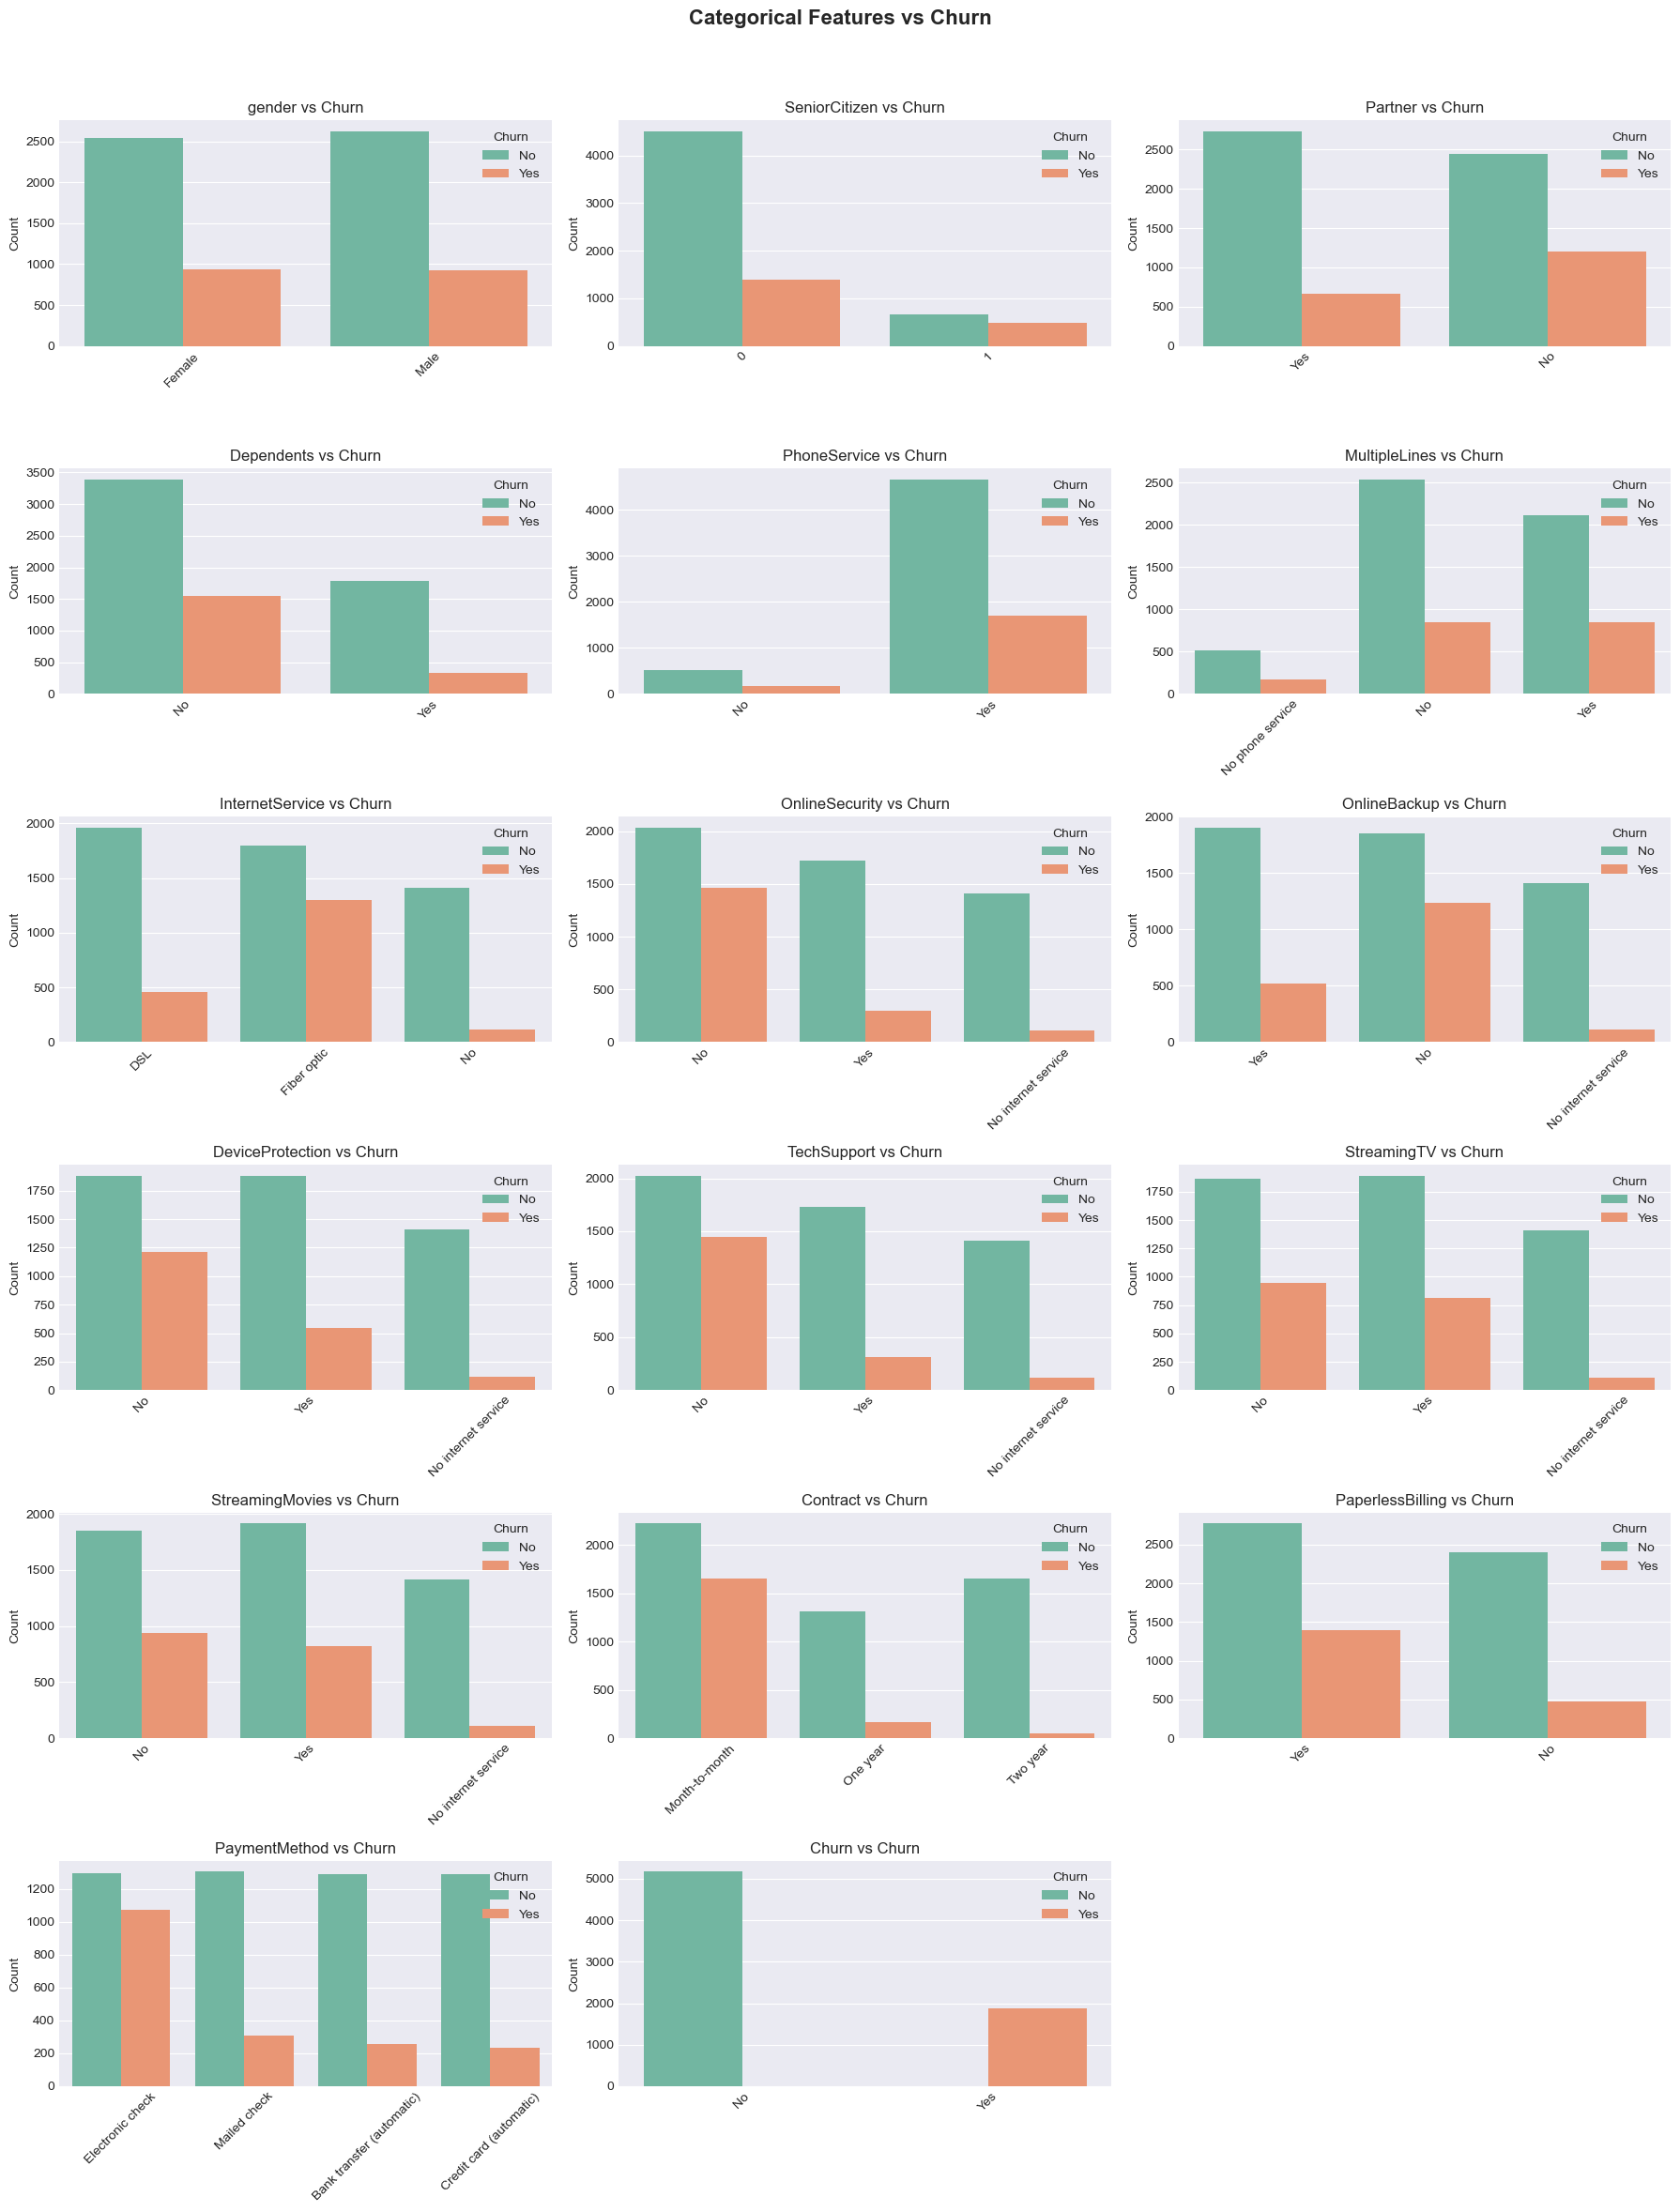

In [78]:
plt.figure(figsize=(18, n_rows * 4))
plt.suptitle("Categorical Features vs Churn", fontsize=16, fontweight='bold')

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=col, hue='Churn', data=eda_data, palette='Set2')
    plt.title(f"{col} vs Churn", fontsize=12)
    plt.xticks(rotation=45)
    plt.xlabel("")
    plt.ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

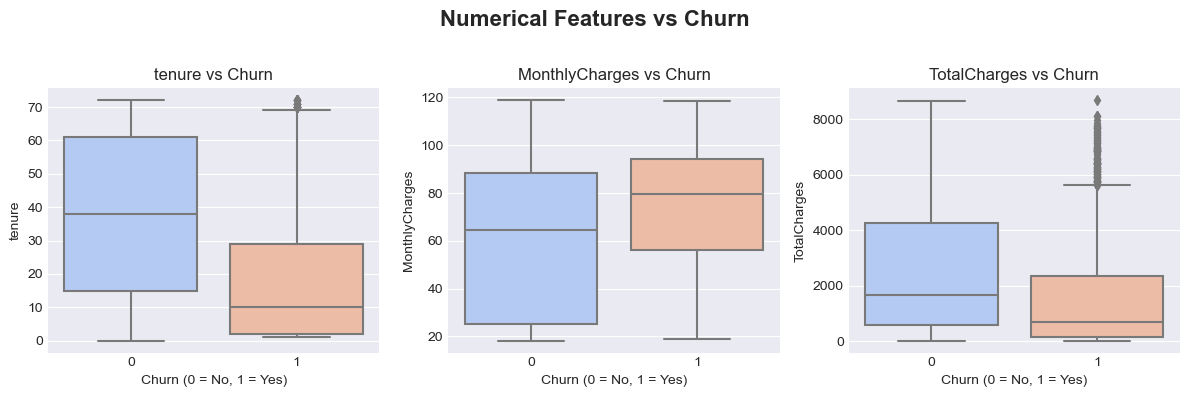

In [79]:
# Set up subplot grid
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

plt.figure(figsize=(12, n_rows * 4))
plt.suptitle("Numerical Features vs Churn", fontsize=16, fontweight='bold')

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='Churn', y=col, data=data, palette='coolwarm')
    plt.title(f"{col} vs Churn", fontsize=12)
    plt.xlabel("Churn (0 = No, 1 = Yes)")
    plt.ylabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<Axes: xlabel='TotalCharges'>

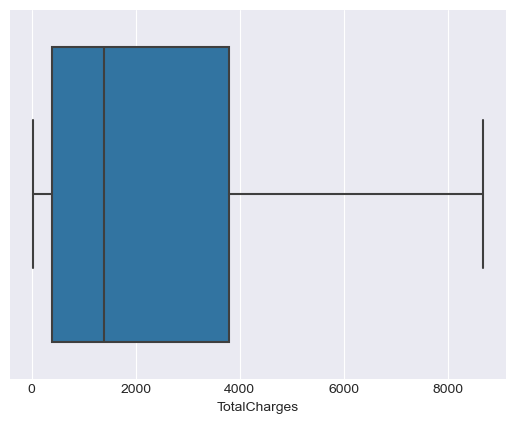

In [80]:
sns.boxplot(x=eda_data['TotalCharges'])

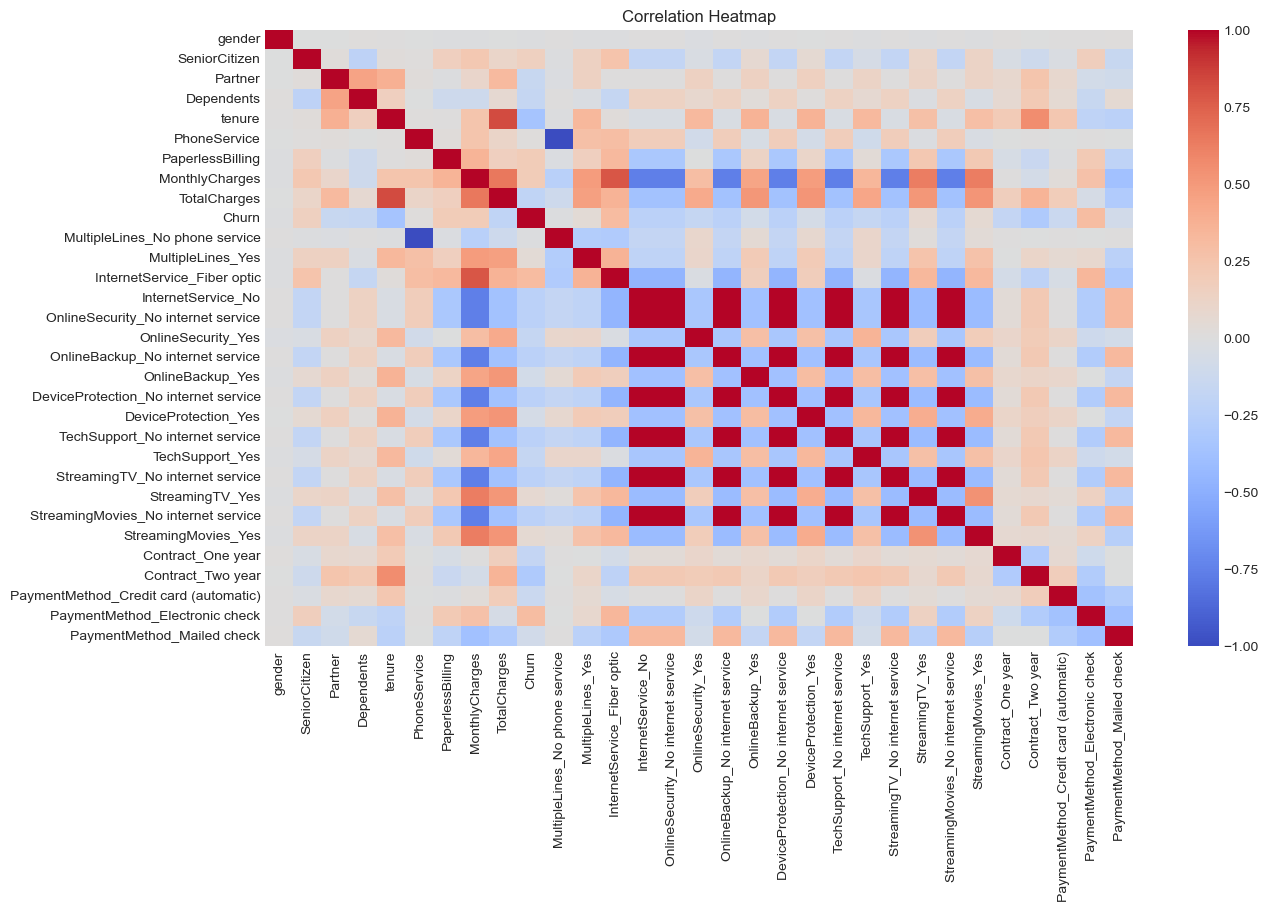

In [81]:
#Correlation Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [84]:
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.8)]
print("Highly correlated features:", high_corr_features)

Highly correlated features: ['TotalCharges', 'MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']


In [85]:
# Combine all 'No internet service' flags into one binary feature
data['NoInternetService'] = data[[
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service',
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
]].max(axis=1)

In [86]:
# Drop the original highly correlated dummy columns
data.drop(columns=[
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service',
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
], inplace=True)

In [87]:
#  Drop if redundant or combine with other phone flags
data.drop(columns=['MultipleLines_No phone service'], inplace=True)

In [88]:
# Check if TotalCharges is derived from MonthlyCharges and tenure
print(data[['TotalCharges', 'MonthlyCharges', 'tenure']].corr().round(2))

                TotalCharges  MonthlyCharges  tenure
TotalCharges            1.00            0.65    0.83
MonthlyCharges          0.65            1.00    0.25
tenure                  0.83            0.25    1.00


In [89]:
data.drop(columns=['TotalCharges'], inplace=True)

In [91]:
data.shape

(7043, 24)

In [92]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'Churn',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'NoInternetService'],
      dtype='object')

# 4. Feature Engineering

In [93]:
# Tenure × MonthlyCharges: proxy for customer value
data['Tenure_MonthlyCharges'] = data['tenure'] * data['MonthlyCharges']

In [94]:
# SeniorCitizen × Contract_Two year: long-term senior customers
data['Senior_LongTerm'] = data['SeniorCitizen'] * data['Contract_Two year']

In [95]:
# NoInternetService × StreamingTV_Yes: flag inconsistency
data['StreamingTV_Conflict'] = data['NoInternetService'] * data['StreamingTV_Yes']

In [96]:
# Tenure buckets
data['TenureGroup'] = pd.cut(data['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '13-24', '25-48', '49-72'])
data = pd.get_dummies(data, columns=['TenureGroup'], drop_first=True)

In [97]:
# Ordinal contract length
data['ContractLength'] = (
    data['Contract_One year'] * 1 +
    data['Contract_Two year'] * 2
)

In [98]:
data['HighRiskPayment'] = data['PaymentMethod_Electronic check']

In [99]:
service_cols = ['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
                'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']
data['ServiceCount'] = data[service_cols].sum(axis=1)

# 5. Model Building

In [106]:
# select numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'ServiceCount', 'Tenure_MonthlyCharges']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [107]:
# split the model
X = data.drop('Churn', axis=1)
y = data['Churn']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [109]:
smote = SMOTE(random_state=42)
X_balanced , y_balanced = smote.fit_resample(X,y)

In [113]:
print("\n Before SMOTE: \n",y_train.value_counts())
print("\n After SMOTE: \n",y_balanced.value_counts())


 Before SMOTE: 
 Churn
0    4138
1    1496
Name: count, dtype: int64

 After SMOTE: 
 Churn
0    5174
1    5174
Name: count, dtype: int64


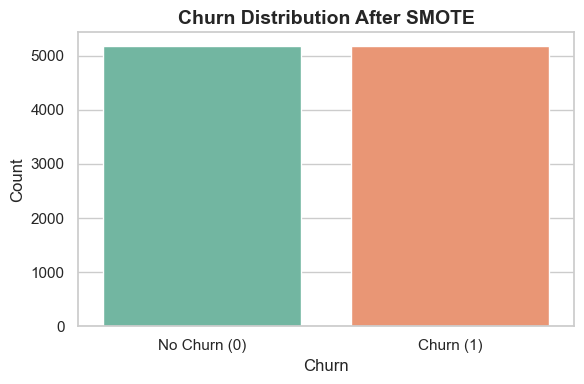

In [114]:
# Plot class distribution after SMOTE
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=y_balanced, palette='Set2')
plt.title("Churn Distribution After SMOTE", fontsize=14, fontweight='bold')
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['No Churn (0)', 'Churn (1)'])
plt.tight_layout()
plt.show()

In [117]:
models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [118]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


Logistic ROC AUC: 0.73
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.56      0.62       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.81      0.81      1409

[[939  97]
 [164 209]]

RandomForest ROC AUC: 0.68
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1036
           1       0.64      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409

[[938  98]
 [200 173]]

XGBoost ROC AUC: 0.71
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1036
           1       0.63      0.52      0.57       373

    accuracy                           0.79      1409
   macr

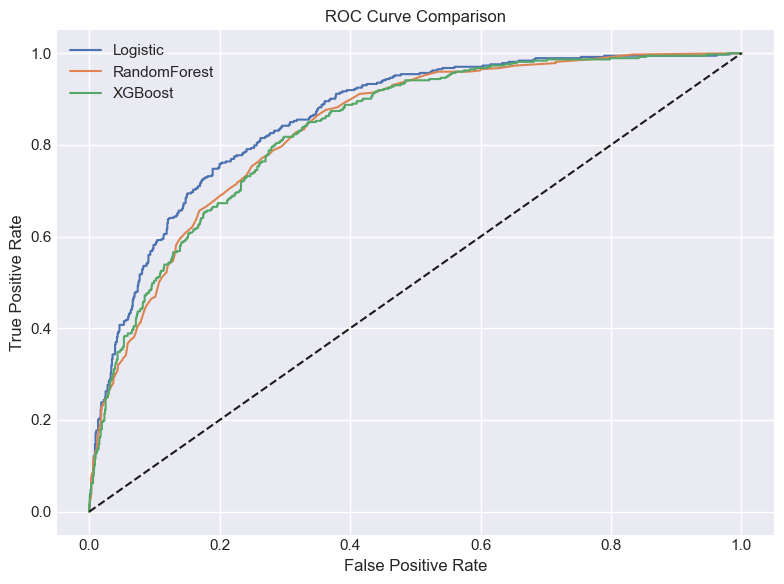

In [120]:
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name}')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
# Predict probabilities for each model
y_proba_log = models['Logistic'].predict_proba(X_test)[:, 1]
y_proba_rf = models['RandomForest'].predict_proba(X_test)[:, 1]
y_proba_xgb = models['XGBoost'].predict_proba(X_test)[:, 1]

# Print ROC AUC scores
print("Logistic Regression ROC AUC Score:", roc_auc_score(y_test, y_proba_log))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))
print("XGBoost ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))

Logistic Regression ROC AUC Score: 0.8590798285838501
Random Forest ROC AUC Score: 0.8352552092498474
XGBoost ROC AUC Score: 0.8333247073193454


# 6. Model Evaluation

In [123]:
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC AUC Score': [0.859, 0.835, 0.833],
    'Accuracy': [0.81, 0.79, 0.79],
    'Precision (Churn)': [0.68, 0.64, 0.63],
    'Recall (Churn)': [0.56, 0.46, 0.52],
    'F1-score (Churn)': [0.62, 0.54, 0.57],
    'False Negatives': [164, 200, 179],
    'False Positives': [97, 98, 113]
}

# Create DataFrame
comparison_df = pd.DataFrame(data)

# Display table
print(comparison_df)


                 Model  ROC AUC Score  Accuracy  Precision (Churn)  \
0  Logistic Regression          0.859      0.81               0.68   
1        Random Forest          0.835      0.79               0.64   
2              XGBoost          0.833      0.79               0.63   

   Recall (Churn)  F1-score (Churn)  False Negatives  False Positives  
0            0.56              0.62              164               97  
1            0.46              0.54              200               98  
2            0.52              0.57              179              113  


In [125]:
import pickle

# Save the Logistic Regression model
with open('customer_churn_model.pkl', 'wb') as f:
    pickle.dump(models['Logistic'], f)

In [126]:
# Load the model
with open('logistic_model.pkl', 'rb') as f:
    logistic_model = pickle.load(f)